# Data Science Fundamentals 5

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2020

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 2.

In [0]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
import umap

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

# ROUTINES

In [0]:
def load_sample_data_pca():
    
    np.random.seed(3)
    eps=0.5
    n=30
    x=np.random.uniform(-1,1,n) 
    y=x+eps*np.random.uniform(-1,1,n)
    x=x-np.mean(x)
    y=y-np.mean(y)
    data=np.vstack((x,y)).transpose()
    
    return data


def load_multidimensional_data_pca(n_data, n_vec, dim, eps ):
    
    points=[]
    vectors=np.random.uniform(-1,1,(dim,n_vec))
    for idata in range(n_data):
        alphas=np.random.normal(size=n_vec)
        points.append(np.sum(np.dot(vectors,np.diag(alphas)),axis=1))
    
    points=np.array(points)
    pert=eps*np.random.normal(size=points.shape)
    
    return points+pert

def load_ex1_data_pca(eps=0.1):
    
    np.random.seed(1231)
    n=30
    x=np.random.uniform(-1,1,n)
        
    y=2*x*x
    
    epsx=eps*np.random.uniform(-1,1,n)
    epsy=eps*np.random.uniform(-1,1,n)

    x=x+epsx
    y=y+epsy

    x=x-np.mean(x)
    y=y-np.mean(y)

    data=np.vstack((x,y)).transpose()
    return data
        
def load_ex2_data_pca(dim=10 , eps=0.0 , seed=8, fat=True, eps1=0.05, n_add=30):
    
    group = np.array([[0.067, 0.21], [0.092, 0.21],
  [0.294, 0.445], [0.227, 0.521], [0.185, 0.597],
  [0.185, 0.689], [0.235, 0.748], [0.319, 0.773],
  [0.387, 0.739], [0.437, 0.672], [0.496, 0.739],
  [0.571, 0.773], [0.639, 0.765], [0.765, 0.924],
  [0.807, 0.933], [0.849, 0.941], [0.118, 0.143], [0.118, 0.176], 
  [0.345, 0.378], [0.395, 0.319], [0.437, 0.261],
  [0.496, 0.328], [0.546, 0.395], [0.605, 0.462],
  [0.655, 0.529], [0.697, 0.597], [0.706, 0.664],
  [0.681, 0.723], [0.849, 0.798], [0.857, 0.849],
  [0.866, 0.899]])
    
    points=[]
    np.random.seed(seed)
    n_data=group.shape[0]
    
    vectors=np.random.uniform(-1,1,(dim,2))
    vectors[:,0]=vectors[:,0]/np.linalg.norm(vectors[:,0])
    vectors[:,1]=vectors[:,1]-np.dot(vectors[:,1],vectors[:,0])*vectors[:,0]
    vectors[:,1]=vectors[:,1]/np.linalg.norm(vectors[:,1])
    
    for idata in range(n_data):
        points.append(np.sum(np.dot(vectors,np.diag(group[idata,:])),axis=1))
    
    points=np.array(points)
    pert=eps*np.random.normal(size=points.shape)
    
    data=points+pert
    
    data=data-np.mean(data,axis=0)
    if (fat):
        data_added={}
        for iadd in range(n_add):
            data_added[iadd]=np.zeros((n_data,dim))
            for idata in range(n_data):
                noise=np.random.uniform(-eps1,eps1,dim)
                data_added[iadd][idata,:]=data[idata,:]+noise[:]
        for iadd in range(n_add):
            data=np.concatenate([data,data_added[iadd]],axis=0)
    
    return data



# Datasets

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

## 1. House prices

Subset of the the hous pricess kaggle dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [0]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  df = pd.read_csv('train.csv', na_values="NaN", keep_default_na=False)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  cleanup_nums = {"Street":      {"Grvl": 0, "Pave": 1},
                  "LotFrontage": {"NA":0},
                  "Alley":       {"NA":0, "Grvl": 1, "Pave": 2},
                  "LotShape":    {"IR3":0, "IR2": 1, "IR1": 2, "Reg":3},
                  "Utilities":   {"ELO":0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
                  "LandSlope":   {"Sev":0, "Mod": 1, "Gtl": 3},
                  "ExterQual":   {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "ExterCond":   {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "BsmtQual":    {"NA":0, "Po":1, "Fa": 2, "TA": 3, "Gd": 4, "Ex":5},
                  "BsmtCond":    {"NA":0, "Po":1, "Fa": 2, "TA": 3, "Gd": 4, "Ex":5},
                  "BsmtExposure":{"NA":0, "No":1, "Mn": 2, "Av": 3, "Gd": 4},
                  "BsmtFinType1":{"NA":0, "Unf":1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ":5, "GLQ":6},
                  "BsmtFinType2":{"NA":0, "Unf":1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ":5, "GLQ":6},
                  "HeatingQC":   {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "CentralAir":  {"N":0, "Y": 1},
                  "Electrical":  {"NA":0, "Mix":1, "FuseP":2, "FuseF": 3, "FuseA": 4, "SBrkr": 5},
                  "KitchenQual": {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "Functional":  {"Sal":0, "Sev":1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2":5, "Min1":6, 'Typ':7},
                  "FireplaceQu": {"NA":0, "Po":1, "Fa": 2, "TA": 3, "Gd": 4, "Ex":5},
                  "PoolQC":      {"NA":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "Fence":       {"NA":0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv":4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [0]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)
    
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)
    
    return features_scaled

## 4. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Let's chech few samples:

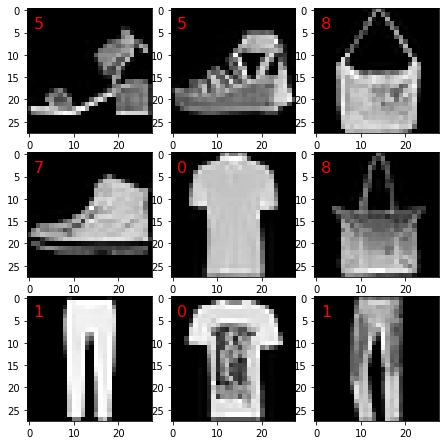

In [36]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
plt.tight_layout(0,0,0)

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# 1.Trees & Forests

## 1. Decision Tree

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning **simple** decision rules inferred from the data features.

They are fast to train, easily interpretable and require small amount of data.

training score : 0.667 (depth=1)


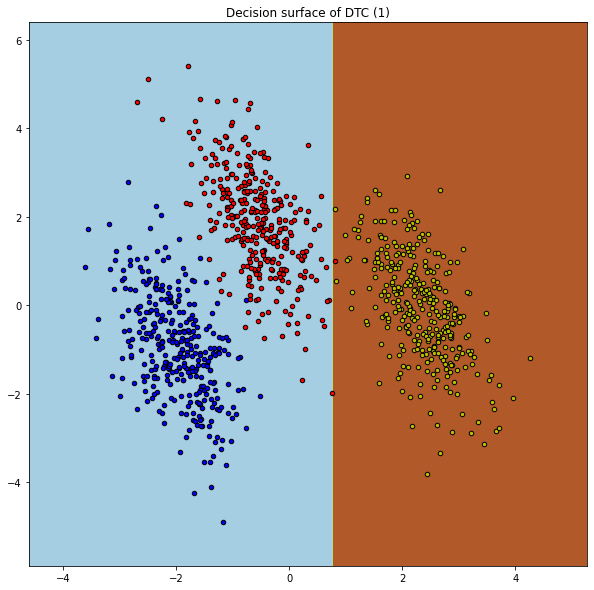

training score : 0.942 (depth=2)


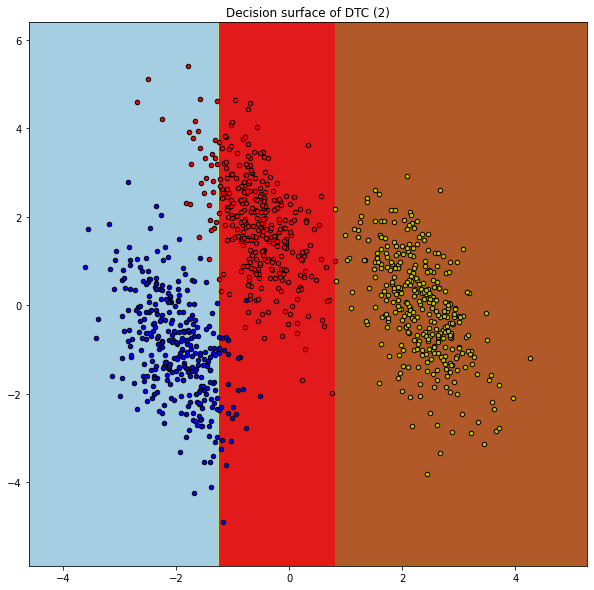

training score : 0.987 (depth=3)


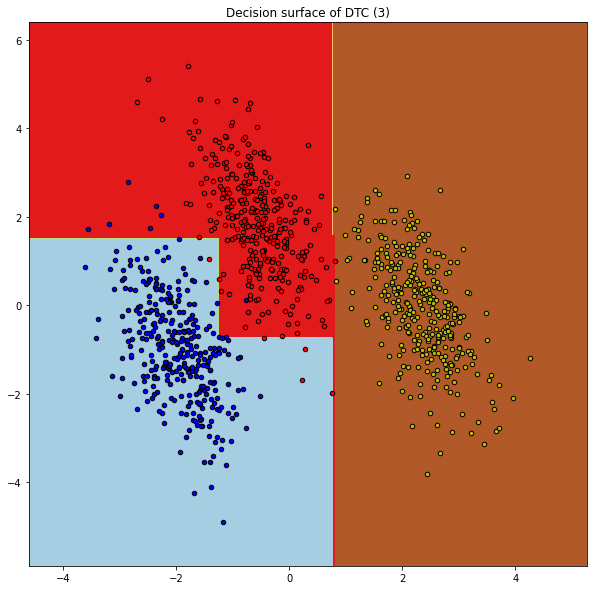

training score : 0.995 (depth=4)


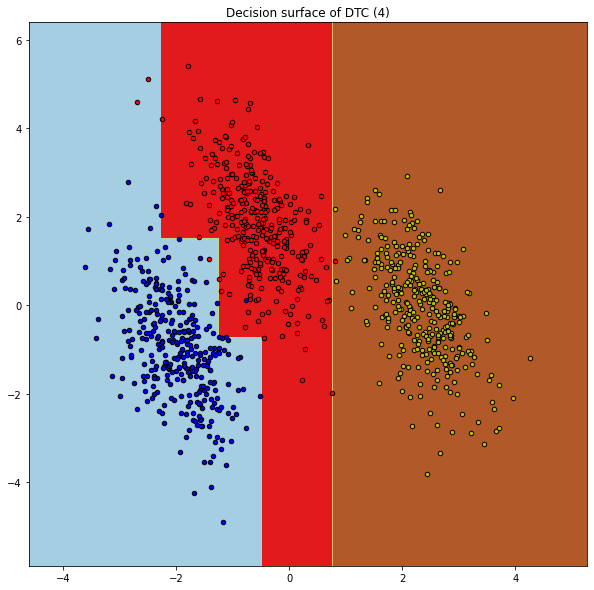

In [37]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)
trees = []
for depth in (1, 2, 3, 4):
    dtc = tree.DecisionTreeClassifier(max_depth=depth)
    trees.append(dtc)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (depth=%d)" % (dtc.score(X, y), depth))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of DTC (%d)" % depth)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(dtc.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
    
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()


    plt.show()

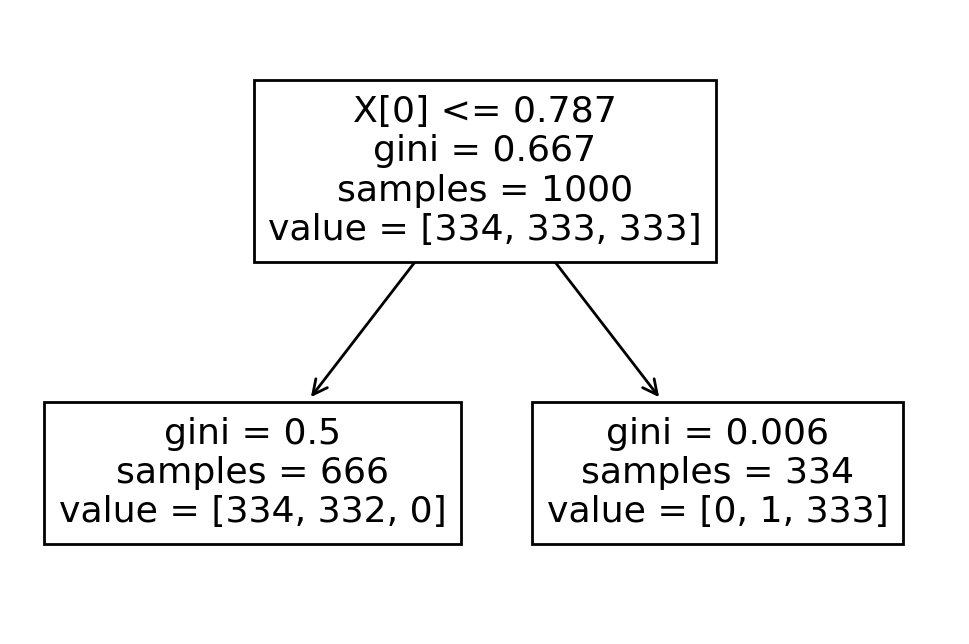

In [38]:
plt.figure(dpi=200)
tree.plot_tree(trees[0]);

## 2.Random Forest

The `sklearn.ensemble` provides sevral enasmble algorithms. RandomForest is an averaging algorithm based on randomized decision trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

Individual decision trees typically exhibit high variance and tend to overfit.
In random forests:
* each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.
* when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset.

The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.


training score : 0.879 (n_est=1)


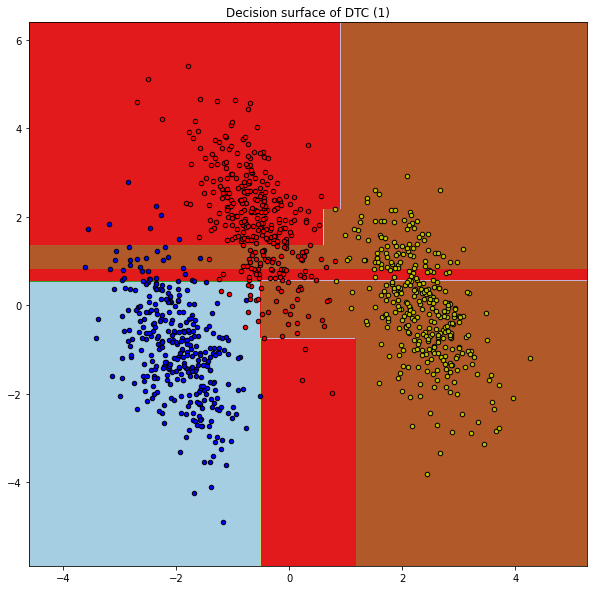

training score : 0.991 (n_est=4)


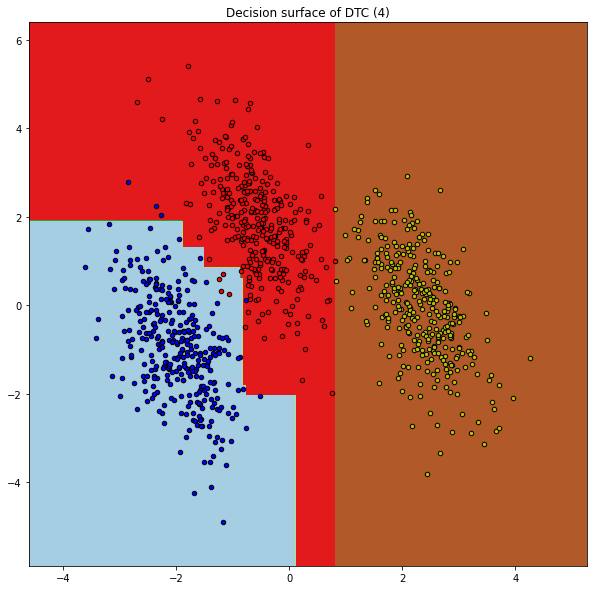

training score : 0.995 (n_est=50)


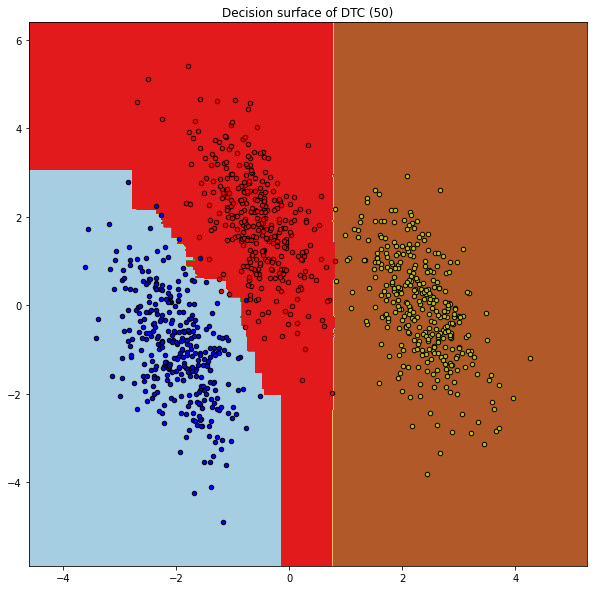

In [39]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for n_est in (1, 4, 50):
    dtc = ensemble.RandomForestClassifier(max_depth=4, n_estimators=n_est)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X, y), n_est))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of DTC (%d)" % n_est)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in enumerate(colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
    
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()


    plt.show()

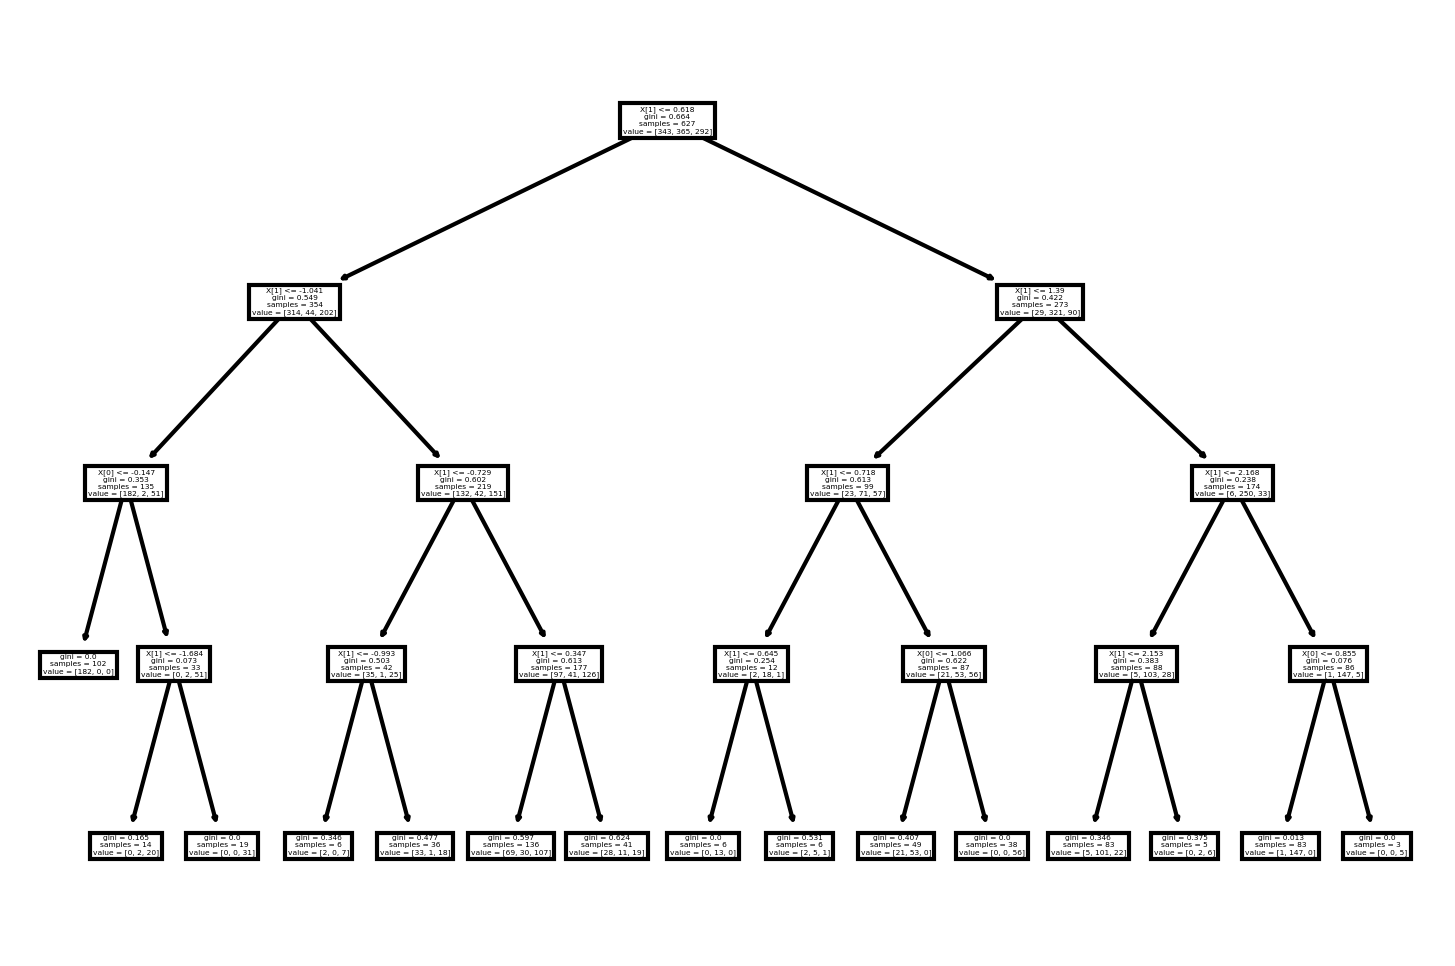

In [40]:
plt.figure(dpi=300)
tree.plot_tree(dtc.estimators_[20]);

## 3. Boosted Decision Trees

Anouther approach to the ensemble tree modeling is Boosted Decision Trees.

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

Boosting is based on weak learners, i.e. shallow trees. In boosting primarily the bias is reduced.


training score : 0.942 (n_est=1)


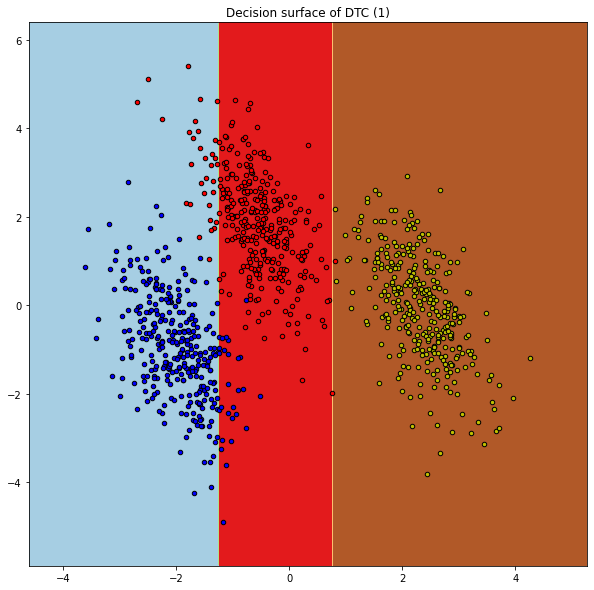

training score : 0.944 (n_est=4)


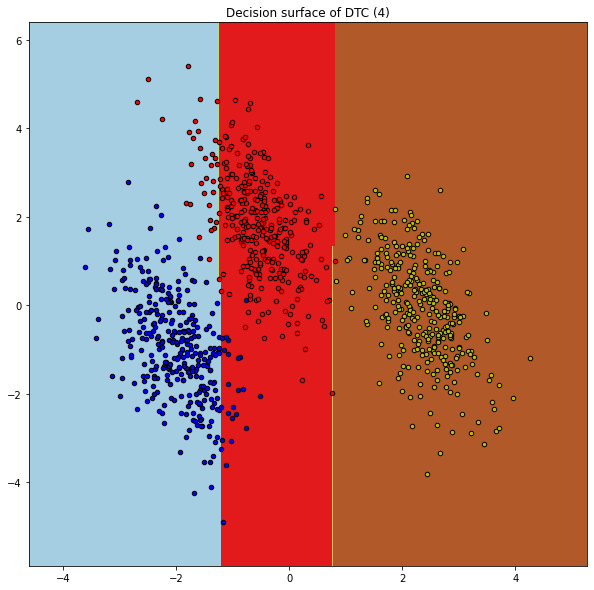

training score : 0.994 (n_est=50)


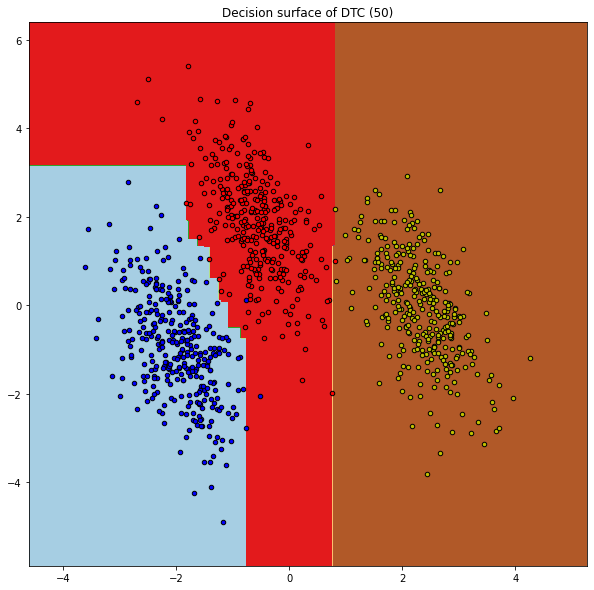

In [41]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for n_est in (1, 4, 50):
    dtc = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=n_est)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X, y), n_est))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of DTC (%d)" % n_est)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in enumerate(colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
    
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()


    plt.show()

## EXERCISE 1.


Classify fashion MNIST images with Random Forest classifier

In [42]:
n = len(train_labels)
x = train_images.reshape((n, -1))
y = train_labels

nt = len(test_labels)
xt = test_images.reshape((nt, -1))
yt = test_labels

n_est = 20

dtc = ensemble.RandomForestClassifier(max_depth=700, n_estimators=n_est, max_leaf_nodes=500)

t1 = timer()
dtc.fit(x, y)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# print the training scores
print("training score : %.3f (n_est=%d)" % (dtc.score(x, y), n_est))
print("test score : %.3f (n_est=%d)" % (dtc.score(xt, yt), n_est))


training time: 11.5s
training score : 0.893 (n_est=20)
test score : 0.855 (n_est=20)


# 2. Unsupervised Learning Techniques


## 1. Principal Component Analysis (PCA)

### Theory overview.

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundance ) and to isolate relevant features.

PCA provides a new set of uncorrelated $M$ features for every data point, with $M < D$. The new features are:

- a linear combination of the original ones ; 
- uncorrelated between each other ; 

**Methods:** Each data point indexed by $p=1..N$ can be seen as an element $\mathbf{x}_p \in \mathbf{R}^D$. 

The variance of the data-cloud measures the spread around its centroid:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  ( \mathbf{x}_p - \mathbf{\overline{x}})^2$$
$$\mathbf{\overline{x}}=\frac{1}{N}\sum_{p=1}^{N} \mathbf{x}_p$$

We fix a number $1\le k \le D$ and consider a subspace $V_k$ of dimension $k$. Each data point  $\mathbf{x}_p$ is projected onto $V_k$, leading to points $\mathbf{x}^k_p$ with spread $S^{2,k}$.  PCA chooses $V_k$ such that the variance $S^{2,k}$ is maximized, as shown in the picture.

![output-onlinepngtools.png](attachment:output-onlinepngtools.png)

In the picture, examples with D=3, k=2.

**Terminology and output of a PCA computation:** 
- *Principal components*: A sequence of orthonormal vectors $k_1,..,k_n$ spanning optimal subspaces: $\text{Span}\{k_1,..,k_m\}=V_m$ ; 
- *Scores*: For every sample-point $p$. the new features are called scores are given by the component of $p$ along the $k$ vectors;  
- *Reconstructed vector:* For every $k$, the projection of $V$ on $V_k$ ;
- *Explained variance*: For every k, the ratio between the variance of the reconstructed vectors and and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot*

### Sklearn: implementation and usage of PCA.

We start showing a two dimensional example that can be easy visualized.

We load the data-sets that we are going to use for the examples:

We have  30 samples of dimension  2


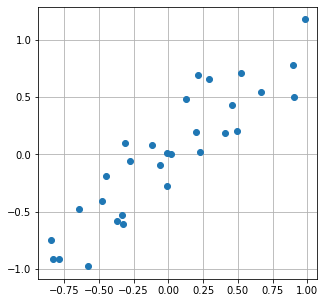

In [43]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [0]:
pca=PCA(n_components=2) 

A call to the pca.fit method computes the principal components

In [47]:
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Now the the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they consitute an orthonormal bases.

(-2.0, 2.0)

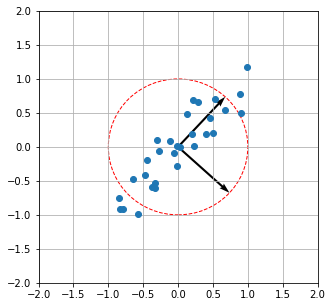

In [48]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1)

plt.xlim(-2,2)
plt.ylim(-2,2)

The pca.explained_variance_ratio_ attribute containes the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [49]:
print(pca.explained_variance_ratio_)

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and than multiply by the basis vectors:

In [0]:
k=1
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

(-1.0, 1.0)

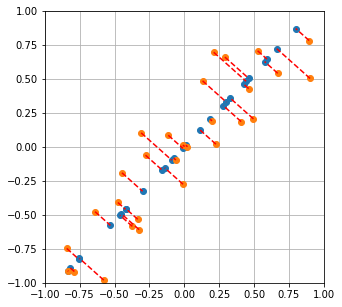

In [51]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)

The same procedure is followed for high dimensional data-sets. Here we generate random data which lies almost on a 6 dimensional subspace. The resulting screen plot can be used to find this result in a semi-automaic fashion.

In [52]:
high_dim_dataset=load_multidimensional_data_pca(n_data=40 ,n_vec=6, dim=20, eps= 0.5)
n_samples,n_dim=high_dim_dataset.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

We have  40 samples of dimension  20


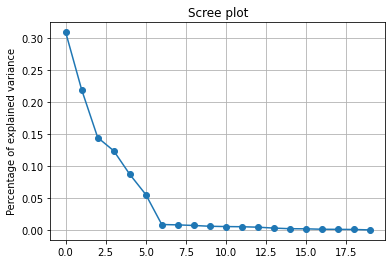

In [53]:
pca=PCA()
pca.fit(high_dim_dataset)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.grid()

As an exercise, you can change the value of eps and see how the screen plot changes.

### EXERCISE 2 : PCA with a non-linear data-set

In this example you will try to do PCA with the simplest non-linear function, a parabola and see what you can get out of it. Start by loading the data.

In [0]:
data=load_ex1_data_pca()

Inspect the data:

We have  30 samples of dimension  2


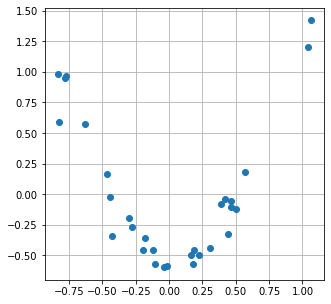

In [55]:
# Ex: inspect the data

# Solution:
n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

In [56]:
# Ex: Define a PCA object and call the fit method 

# Solution:
pca=PCA()
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [57]:
# Ex: Print the explained variance. What values of k does it make sense to choose ?

# Solution:
print(pca.explained_variance_ratio_)

[0.57388642 0.42611358]


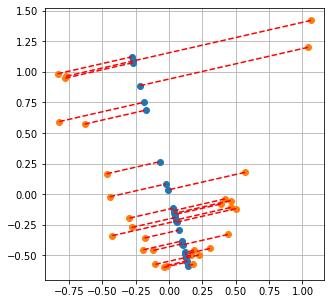

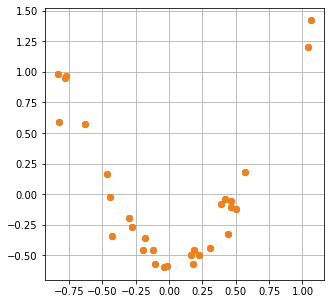

In [58]:
# Choose the best k and print the reconstructed vectors. Is the result expected ?

# Solution:
scores=pca.transform(data)
for k in range(1,3):
    res=np.dot(scores[:,:k], pca.components_[:k,:]) 

    plt.figure(figsize=((5,5)))
    plt.plot(res[:,0],res[:,1],'o')
    plt.plot(data[:,0],data[:,1],'o')

    for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
        plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

    plt.grid()

    #plt.xlim(-1.0,1.0)
    #plt.ylim(-1.0,1.0)

**Message:** if the manyfold is non-linear one is forced to use a high number of principal components. For example, in the parabola example the projection for k=1 looks bad. But using too many principal components the reconstructed vectors are almost equal to the original ones (for k=2 we get exact reconstruction in our example ) and the advanteges of dimensionality reduction are lost. This is a general pattern.

### EXERCISE 3 : Find the hidden drawing.

In this exercise you will take a high dimensional data-set, find the optimal number of principal components and visualize the reconstructed vectors with k=2.

Start by loading the dataset:

In [0]:
data= load_ex2_data_pca(seed=1235)

In [60]:
# Ex: Define a PCA object and call the fit method 

# Solution:
pca=PCA()
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[0.79700994 0.15407412 0.00688753 0.00667879 0.00652795 0.00605738
 0.00596107 0.00576693 0.00561825 0.00541804]


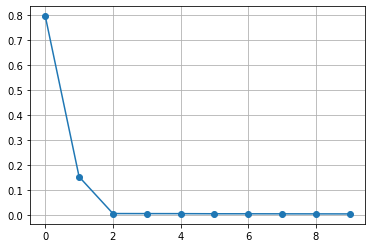

In [61]:
# Ex: find the optimal k. Either print the values of the explained variance or produce a scree plot

# Solution: 
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.grid()

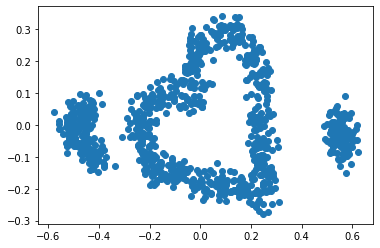

In [62]:
# Ex: Compute the reconstructed vectors for the optimal k value that you found and print them

# Solution:
k=2
data_transformed=pca.transform(data)
plt.plot(data_transformed[:,0],data_transformed[:,1],'o')

Could you have found the result hidden in the data without PCA?

**Message:** Sometimes the data hides simple patterns in high dimensional datasets. PCA can be very useful in identifying these patterns.

## 2. Data visualization ( t-SNE / UMAP )

### Theory overview

PCA is a linear embedding technique where the scores are a linear function of the original variables. This forces the number of principal components to be used to be high, if the manyfold is highly non-linear. Curved manyfolds needs to be embedded in higher dimensions.

Other non-linear embedding techniques consider more generic embeddings and try to minimize the loss of information according to different criteria, either statistical (t-SNE) or based on advanced topological descriptions (UMAP). It is not the goal of this short introduction to discuss the derivation of such approaches.

In the following, we will show how to apply practically these dimensionality reductions techniques. Keep in mind that the embedding is given by an iterative solution of a minimizazion problem and therefore the results may depend on the value of the random seed.

### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [0]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(random_state=1711)

### Example 1: Exercise 3 Cont'd

We first of all visualize our multi-dimensional heart using t-sne: 

In [9]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=100 )

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.060286
[t-SNE] Computed conditional probabilities in 0.046s
[t-SNE] Iteration 50: error = 10.6543236, gradient norm = 0.0495624 (50 iterations in 6.418s)
[t-SNE] Iteration 100: error = 10.5105200, gradient norm = 0.0211065 (50 iterations in 6.915s)
[t-SNE] Iteration 150: error = 10.4393597, gradient norm = 0.0135420 (50 iterations in 6.418s)
[t-SNE] Iteration 200: error = 10.3963032, gradient norm = 0.0162105 (50 iterations in 8.220s)
[t-SNE] Iteration 250: error = 10.3679466, gradient norm = 0.0112098 (50 iterations in 15.311s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.367947
[t-SNE] Iteration 300: error = 0.6041823, gradient norm = 0.0007995 (50 iterations in 8.216s)
[t-SNE] KL divergence after 300 iterations: 0.604182


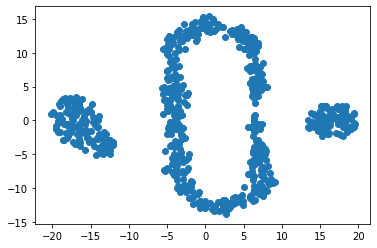

In [10]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])

And using UMAP :

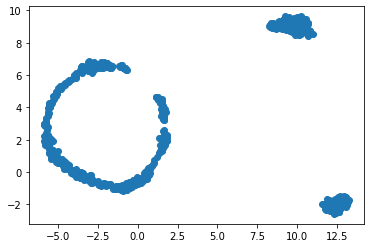

In [13]:
umap_model = umap.UMAP(random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])

### Example 2: Mnist dataset

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 50
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [7]:
tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
                  early_exaggeration=4.0,init='pca', 
                  n_iter=300, random_state=2233212, 
                  metric='euclidean', verbose=100, n_jobs=1)

tsne_mnist = tsne_model.fit_transform(data)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 2.996414
[t-SNE] Computed conditional probabilities in 0.009s
[t-SNE] Iteration 50: error = 14.9988317, gradient norm = 0.2322012 (50 iterations in 32.026s)
[t-SNE] Iteration 100: error = 15.0905781, gradient norm = 0.2146315 (50 iterations in 9.214s)
[t-SNE] Iteration 150: error = 14.3254852, gradient norm = 0.2790214 (50 iterations in 10.807s)
[t-SNE] Iteration 200: error = 14.1045866, gradient norm = 0.2771865 (50 iterations in 9.024s)
[t-SNE] Iteration 250: error = 14.5626040, gradient norm = 0.2542749 (50 iterations in 10.926s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 14.562604
[t-SNE] Iteration 300: error = 1.5061481, gradient norm = 0.0065419 (50 iterations in 8.791s)
[t-SNE] KL divergence after 300 iterations: 1.506148


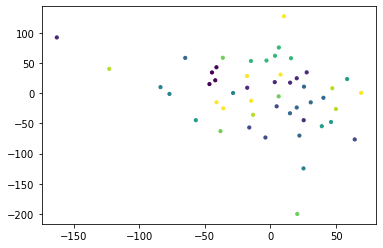

In [8]:
plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)

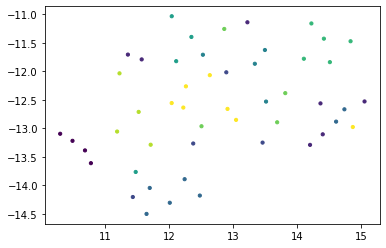

In [10]:
umap_model = umap.UMAP(random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)

### Example 3: Fashion_Mnist dataset

In [0]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [0]:
tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

tsne_fmnist = tsne_model.fit_transform(data)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.882s...
[t-SNE] Computed neighbors for 5000 samples in 32.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.071947
[t-SNE] Computed conditional probabilities in 0.264s
[t-SNE] Iteration 50: error = 15.0192137, gradient norm = 0.0023564 (50 iterations in 6.971s)
[t-SNE] Iteration 100: error = 15.2161541, gradient norm = 0.0002592 (50 iterations in 6.875s)
[t-SNE] Iteration 150: error = 15.2404537, gradient norm = 0.0001710 (50 iterations in 7.071s)
[t-SNE] Iteration 200: error = 15.2466249, gradient norm = 0.0001307 (50 iterations in 7.243s)
[t-SNE] Iteration 250: error = 15.2495413, gradient norm = 0.00010

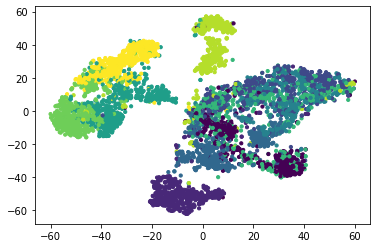

In [0]:
plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)

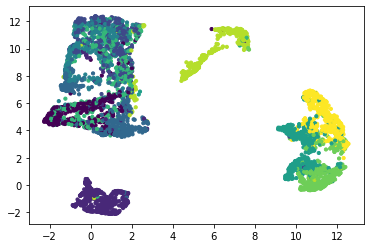

In [12]:
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)

### Example 4: House prices

In [0]:
data=house_prices_dataset_normed()

In [16]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200,
                  early_exaggeration=4.0,init='pca', n_iter=1000,
                  random_state=2233212, metric='euclidean', verbose=100)
tsne_houses = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1460 samples in 0.015s...
[t-SNE] Computed neighbors for 1460 samples in 0.472s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1460
[t-SNE] Computed conditional probabilities for sample 1460 / 1460
[t-SNE] Mean sigma: 1.273030
[t-SNE] Computed conditional probabilities in 0.264s
[t-SNE] Iteration 50: error = 15.2652950, gradient norm = 0.0018213 (50 iterations in 477.825s)


KeyboardInterrupt: ignored

In [0]:
plt.scatter(tsne_houses[:,0],tsne_houses[:,1],s=20)

In [0]:
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)

**Message:** Visualization techniques are useful for having an initial grasp of multi-dimensional datasets and guide further analsis and the choice of the modelling data strategy.